### Laboratorium 6 - część 2/2

W tej części zajmiesz się wykorzystaniem punktów kluczowych do dwóch popularnych zadań: wyszukiwania obszarów podobnych oraz łączenia obrazów (_image stitching_).

Przeczytaj treść całej instrukcji przed przystąpieniem do działania!

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Zadanie 3

Dane są obrazy `coke` i `table`. Wykorzystaj metodologię parowania punktów kluczowych do znalezienia wystąpienia puszki z Colą na stole. To zadanie jest podzielone na kilka kamieni milowych - czytaj dalej.

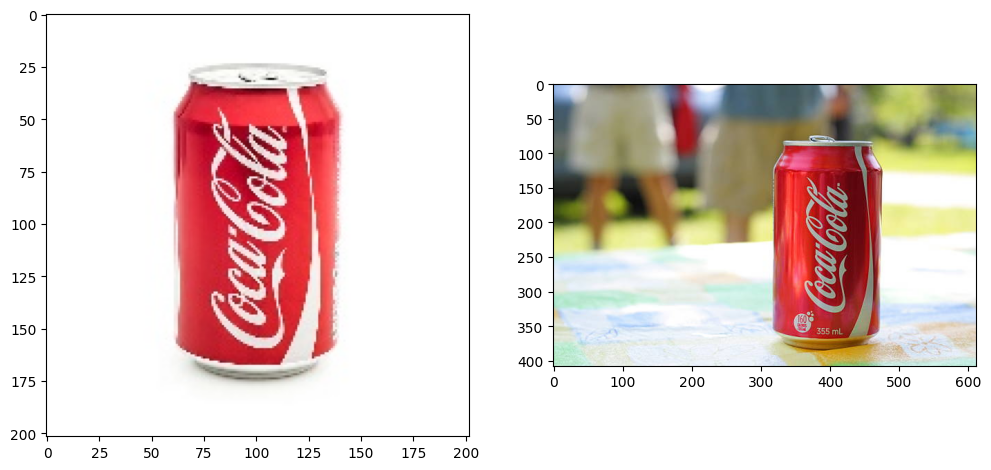

In [2]:
coke = cv2.imread('Data/coke.jpg')
table = cv2.imread('Data/coke-table.jpg')
f, (a1, a2) = plt.subplots(1, 2, figsize=(12,12))
a1.imshow(coke[..., ::-1]);
a2.imshow(table[..., ::-1]);

##### Zadanie 3a

Wykonaj detekcję punktów kluczowych i ich parowanie z użyciem dowolnego matchera. Wykonaj filtrację znalezionych par po dystansie - co obserwujesz, zmieniając próg?

In [3]:
def find_keypoints(image, contrastThreshold, edgeThreshold):
    sift_instance = cv2.SIFT_create()
    # 'image' powinno być obrazem jednokanałowym (jeśli nie, zostanie zastosowane cvtColor z flagą COLOR_BGR2GRAY)
    keypoints = sift_instance.detect(image)
    keypoints, descriptors = sift_instance.compute(image, keypoints) #detectAndCompute(image, mask=None)
    return keypoints, descriptors

Text(0.5, 1.0, 'B (295 punktów)')

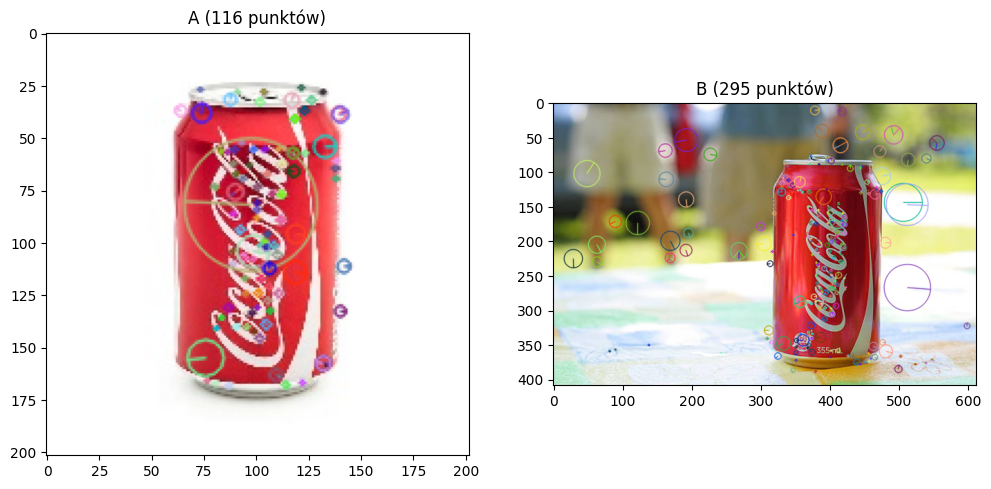

In [4]:
coke_keypoints, coke_descriptors = find_keypoints(coke, contrastThreshold=0.05, edgeThreshold=0.05)
table_keypoints, table_descriptors = find_keypoints(table, contrastThreshold=0.05, edgeThreshold=0.05)

f, (a1, a2) = plt.subplots(1,2,figsize=(12,12))
d_coke = cv2.drawKeypoints(coke, coke_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
d_table = cv2.drawKeypoints(table, table_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
a1.imshow(d_coke[..., ::-1])
a1.set_title('A ({} punktów)'.format(len(coke_keypoints)))
a2.imshow(d_table[..., ::-1])
a2.set_title('B ({} punktów)'.format(len(table_keypoints)))

In [5]:
# matcher = cv2.BFMatcher_create()
# best_matches = matcher.match(coke_descriptors, table_descriptors)
# print(len(best_matches), type(best_matches[0]))

# print('Punkty {} i {}, odległość = {:.3f}'.format(
#     best_matches[0].queryIdx,
#     best_matches[0].trainIdx,
#     best_matches[0].distance
# ))

In [6]:
def get_knn_matches(descriptors_1, descriptors_2, k=2):
    matcher = cv2.BFMatcher_create()
    best_k_matches = matcher.knnMatch(descriptors_1, descriptors_2, k=k)
    print(f'Wymiary dopasowania: {len(best_k_matches)}, {len(best_k_matches[0])}')
    return best_k_matches

Wymiary dopasowania: 116, 2


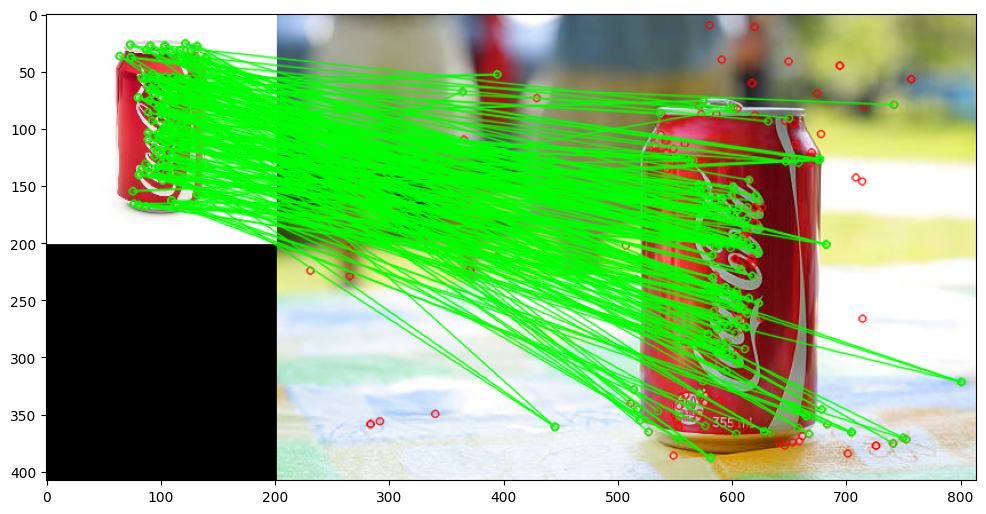

In [7]:
knn_matches = get_knn_matches(coke_descriptors, table_descriptors)
#show_matches = cv2.drawMatches(coke, coke_keypoints, table, table_keypoints, knn_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
show_matches = cv2.drawMatchesKnn(coke, coke_keypoints, table, table_keypoints, knn_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1]);

In [8]:
# TODO: wykonaj filtracje par po dystansie. co obserwujesz zmieniajac prog?

##### Zadanie 3b

Powtórz detekcję z użyciem k-najlepszych wyników (dla niewielkiego k, np. 2 lub 3). Zaproponuj prosty sposób wykrywania sytuacji, w których jeden punkt jest podobnie bliski innym i użyj go do odfiltrowania wyników, tak aby pozostawić te bardziej unikatowe dopasowania. *Czy unikatowe znaczy dobre?*

Wymiary dopasowania: 116, 2


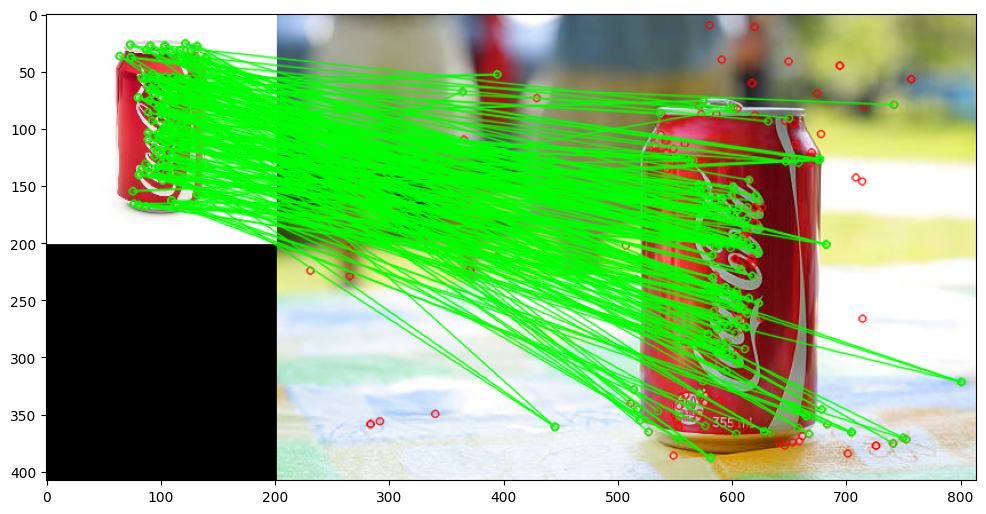

In [9]:
knn_matches = get_knn_matches(coke_descriptors, table_descriptors)
#show_matches = cv2.drawMatches(coke, coke_keypoints, table, table_keypoints, knn_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
show_matches = cv2.drawMatchesKnn(coke, coke_keypoints, table, table_keypoints, knn_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1]);

In [10]:
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

In [11]:
type(knn_matches)

tuple

In [12]:
good = []
for m, n in knn_matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

filtered_coke_keypoints = np.float32([ coke_keypoints[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
filtered_table_keypoints = np.float32([ table_keypoints[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
#show_matches = cv2.drawMatchesKnn(coke, filtered_coke_keypoints, table, filtered_table_keypoints, knn_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
#plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1]);


##### Zadanie 3c

Znajdź transformację geometryczną dla par dopasowanych punktów, tak aby przekształcić `coke` (*train*) do geometrii `table` (query). Zademonstruj poprawność, zestawiając obok siebie przekształconą wersję `coke` oraz oryginalny `table`, bądź nanosząc jedno na drugie. Zidentyfikuj punkty, które znaleziona transformacja przekształca "dobrze", tzn. ich współrzędne po przekształceniu leżą w pobliżu odpowiadających im punktów z drugiego obrazu; nanieś je na obraz.

*Jak na wyniki wpływa wykrycie większej lub mniejszej liczby punktów kluczowych na etapie SIFT? W jakim stopniu wstępna filtracja poprawia rezultaty? Jak działa i jaką rolę w procesie parowania odgrywa RANSAC?*

*\"Na piątkę\"*: znajdź rejon zainteresowania (RoI), tj. prostokąt otaczający zidentyfikowane właśnie punkty, a następnie oblicz błąd średniokwadratowy między obrazami w tym rejonie (albo dowolną miarę podobieństwa). Bonus: użyj [`cv2.convexHull`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) do narysowania maski wybierającej tylko piksele znajdujące się wewnątrz wielokąta otaczającego "dobrze" dopasowane punkty, by liczyć miarę podobieństwa jedynie wewnątrz tego obszaru.

In [14]:
M, mask = cv2.findHomography(filtered_coke_keypoints, filtered_table_keypoints, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h, w = coke.shape[0], coke.shape[1]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(table,[np.int32(dst)],True,255,3, cv2.LINE_AA)

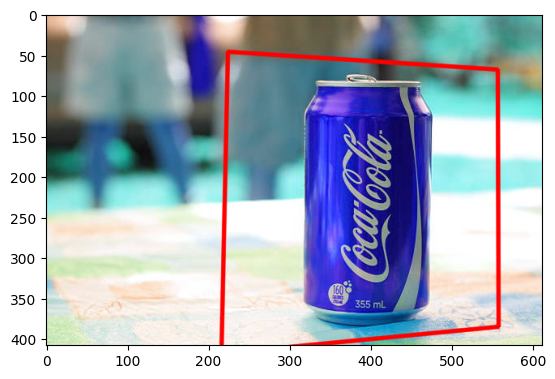

(<matplotlib.image.AxesImage at 0x7fb81c2be760>, None)

In [15]:
plt.imshow(img2, 'gray'),plt.show()

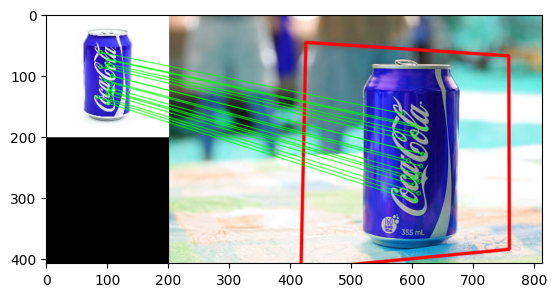

(<matplotlib.image.AxesImage at 0x7fb81c260490>, None)

In [17]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(coke, coke_keypoints, img2, table_keypoints, good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

#### Zadanie 4

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być zupełnie dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy zawierały jakieś punkty charakterystyczne. (Może posiadasz jakieś ciekawe dane z własnego projektu, które możesz tu wykorzystać?)

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o połowę-2/3 szerokości klatki)
* większe przesunięcie (o 3/4-4/5 szerokości)
* przesunięcie z rotacją w osi kamery
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Celem zadania będzie przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia (_stitching_) obrazów. Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3c) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary tworzonych w ten sposób obrazów są wystarczające do zmieszczenia obu składowych. Jeśli rozwiązujesz zadanie 3c w wariancie _\"na piątkę\"_, użyj tej metody oceny również w tym zadaniu.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jaka jest jakość dopasowania? Jeśli dla którejś pary algorytm zawiódł - dlaczego?*